In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats

import plot_utils as pu
from digest import conds, get_digest_output, get_voltages
import isi_indexing as ii
from readout import load_results
import digest

import conf.isi5_500 as cfg

In [2]:
def label(STD, TA):
    if STD and TA:
        return 'STD+TA'
    elif STD:
        return 'STD only'
    elif TA:
        return 'TA only'
    return 'no plasticity'

In [3]:
def align(acontrast):
    sample = next(iter(acontrast.values()))
    total = sum([np.abs(c) for c in acontrast.values()])
    valid = (total!=0) & ~np.isnan(sample)
    t0 = (valid.cumsum(1)==0).sum(1)
    t1 = valid.shape[1] - (np.flip(valid, 1).cumsum(1)==0).sum(1)
    tmax = (t1-t0).max()
    if tmax < 0:
        tmax = 0
        t0 = t1
    kidx = np.repeat(np.arange(sample.shape[0]).reshape(-1,1), tmax, 1)
    tidx = np.repeat(np.arange(tmax).reshape(1,-1), sample.shape[0], 0) + t0.reshape(-1,1)
    return kidx, tidx, tmax

In [4]:
isi = cfg.ISIs[0]
templ = 0
TA = 1
nonstandard = ('dev', 'msc')
measures = ('Threshold', 'Depression', 'Synapses', 'Reset', 'Vm')
contrasts = {STD: {TA: {measure: [] for measure in measures} for TA in cfg.TAs} for STD in cfg.STDs}
voltages = {STD: {TA: {cond: {measure: [] for measure in measures} for cond in conds} for TA in cfg.TAs} for STD in cfg.STDs}
tmax_v, tmax_c = {STD: {TA: 0 for TA in cfg.TAs} for STD in cfg.STDs}, {STD: {TA: 0 for TA in cfg.TAs} for STD in cfg.STDs}
for STD in cfg.STDs:
    for TA in cfg.TAs:
        for net in range(cfg.N_networks):
            res = load_results(
                cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ),
                compress=True, dynamics_supplements={'u': 'v', 'th_adapt': 0})
            for ipair, pair in enumerate(cfg.pairings):
                for istim, stim in enumerate(pair):
                    hist = {cond: {} for cond in conds}
                    for cond in conds:
                        data = res['dynamics'][ipair][stim][cond]
                        V = {measure: v.mean(1) for measure, v in get_voltages(cfg.params, data).items()}
                        for measure, v in V.items():
                            voltages[STD][TA][cond][measure].append(v)
                            hist[cond][measure] = v
                            tmax_v[STD][TA] = max(tmax_v[STD][TA], v.shape[1])
                        hist[cond]['pspike'] = res['spikes'][ipair][stim][cond]['spike_hist']
                    pdiff = hist['dev']['pspike'] - hist['msc']['pspike']
                    mask = pdiff > .05
                    for measure in measures:
                        c = (hist['dev'][measure] - hist['msc'][measure])/mV
                        c[~mask] = np.nan
                        contrasts[STD][TA][measure].append(np.nansum(c*pdiff, 0))
            print(net, end=' ')
        contrasts[STD][TA] = {
            measure: np.asarray([
                np.concatenate([c, np.full_like(c, np.nan, shape=tmax_v[STD][TA]-len(c))])
                for c in contrast
            ])
            for measure, contrast in contrasts[STD][TA].items()}
        tmax_c[STD][TA] = align(contrasts[STD][TA])[2]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [5]:
for STD in cfg.STDs:
    for TA in cfg.TAs:
        for measure in measures:
            contrasts[STD][TA][measure] = contrasts[STD][TA][measure][:, :tmax_c[STD][TA]]
            for cond in conds:
                voltages[STD][TA][cond][measure] = np.asarray([
                    np.concatenate([v, np.full_like(v, np.nan, shape=[v.shape[0], tmax_v[STD][TA]-v.shape[1]])], axis=1)
                    for v in voltages[STD][TA][cond][measure]
                ])

In [ ]:
dd.io.save('Fig5o-stats.contrasts.h5', contrasts)
dd.io.save('Fig5o-stats.voltages.STD0.h5', voltages[0])
dd.io.save('Fig5o-stats.voltages.STD1.h5', voltages[1])

In [6]:
contrasts = dd.io.load('Fig5o-stats.contrasts.h5')
# voltages = {0: dd.io.load('Fig5o-stats.voltages.STD0.h5'), 1: dd.io.load('Fig5o-stats.voltages.STD1.h5')}

In [7]:
plotted_measures = ('Threshold', 'Depression', 'Synapses')

WARNING    /tmp/ipykernel_705443/2542118406.py:7: RuntimeWarning: invalid value encountered in true_divide
  ratio = np.abs(contrast) / sum([np.abs(c) for c in contrasts[STD][TA].values()])
 [py.warnings]
WARNING    /home/felix/projects/culture/.env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
 [py.warnings]


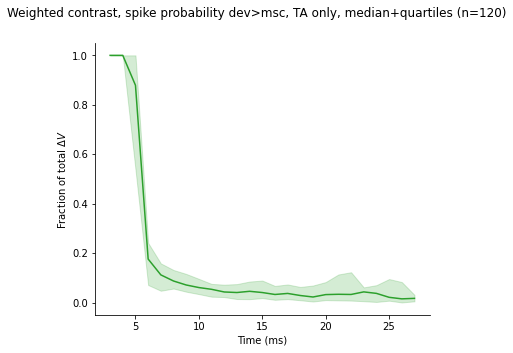

In [26]:
STD, TA = 0, 1
nsamples = cfg.N_networks * len(cfg.pairings) * 2
fig1, ax1 = plt.subplots(figsize=(6,5), sharex=True)
fig1.suptitle(f'Weighted contrast, spike probability dev>msc, {label(STD, TA)}, median+quartiles (n={nsamples})')
contrast = contrasts[STD][TA]['Threshold']
time = np.arange(contrast.shape[-1]) * cfg.params['dt'] / msecond
ratio = np.abs(contrast) / sum([np.abs(c) for c in contrasts[STD][TA].values()])
q = np.nanquantile(ratio, (.25, .5, .75), 0)
ax1.fill_between(time, q[0], q[2], color=pu.colors['Threshold'], alpha=.2)
ax1.plot(time, q[1], color=pu.colors['Threshold'], label=pu.labels['Threshold'])
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Fraction of total $\\Delta V$')
sns.despine(ax=ax1)

WARNING    /tmp/ipykernel_82148/1087931975.py:21: RuntimeWarning: invalid value encountered in true_divide
  ratio = np.abs(contrast) / sum([np.abs(c[:, :tlen]) for c in contrasts[STD][TA].values()])
 [py.warnings]
WARNING    /home/felix/projects/culture/.env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
 [py.warnings]


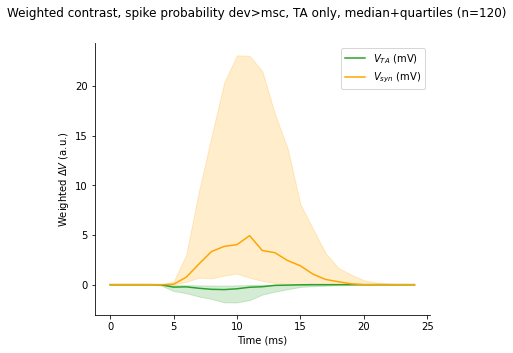

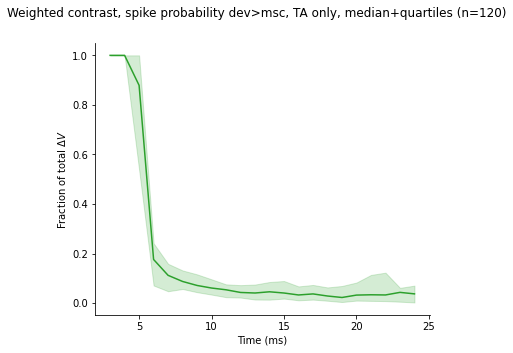

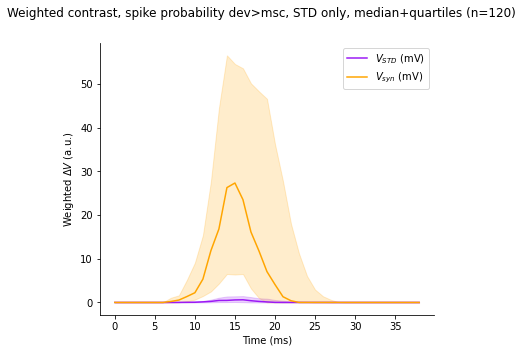

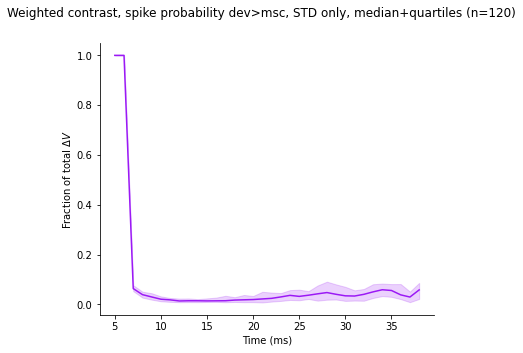

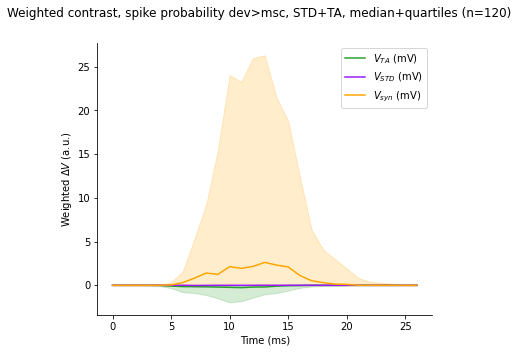

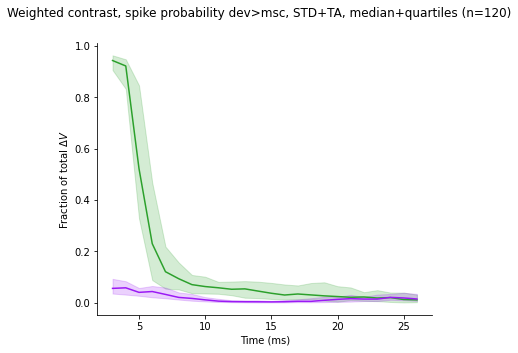

In [59]:
nsamples = cfg.N_networks * len(cfg.pairings) * 2
for STD in cfg.STDs:
    for TA in cfg.TAs:
        if STD+TA == 0:
            continue
        fig0, ax0 = plt.subplots(figsize=(6,5), sharex=True)
        fig1, ax1 = plt.subplots(figsize=(6,5), sharex=True)
        fig0.suptitle(f'Weighted contrast, spike probability dev>msc, {label(STD, TA)}, median+quartiles (n={nsamples})')
        fig1.suptitle(f'Weighted contrast, spike probability dev>msc, {label(STD, TA)}, median+quartiles (n={nsamples})')
        kidx, tidx, tlen = align(contrasts[STD][TA])
        time = np.arange(tlen) * cfg.params['dt'] / msecond
        for measure, contrast in contrasts[STD][TA].items():
            if measure not in plotted_measures or (measure=='Threshold' and not TA) or (measure=='Depression' and not STD):
                continue
            contrast = contrast[:, :tlen]
            q = np.nanquantile(contrast, (.25, .5, .75), 0)
            ax0.fill_between(time, q[0], q[2], color=pu.colors[measure], alpha=.2)
            ax0.plot(time, q[1], color=pu.colors[measure], label=pu.labels[measure])

            if measure in ('Depression', 'Threshold'):
                ratio = np.abs(contrast) / sum([np.abs(c[:, :tlen]) for c in contrasts[STD][TA].values()])
                q = np.nanquantile(ratio, (.25, .5, .75), 0)
                ax1.fill_between(time, q[0], q[2], color=pu.colors[measure], alpha=.2)
                ax1.plot(time, q[1], color=pu.colors[measure], label=pu.labels[measure])
        for ax in [ax0, ax1]:
            ax.set_xlabel('Time (ms)')
        ax0.set_ylabel('Weighted $\\Delta V$ (a.u.)')
        ax1.set_ylabel('Fraction of total $\\Delta V$')
        ax0.legend()
        sns.despine(fig0)
        sns.despine(fig1)

WARNING    /tmp/ipykernel_54294/2764456174.py:9: RuntimeWarning: Mean of empty slice
  m, s = np.nanmean(contrast, 0), np.nanstd(contrast, 0)
 [py.warnings]


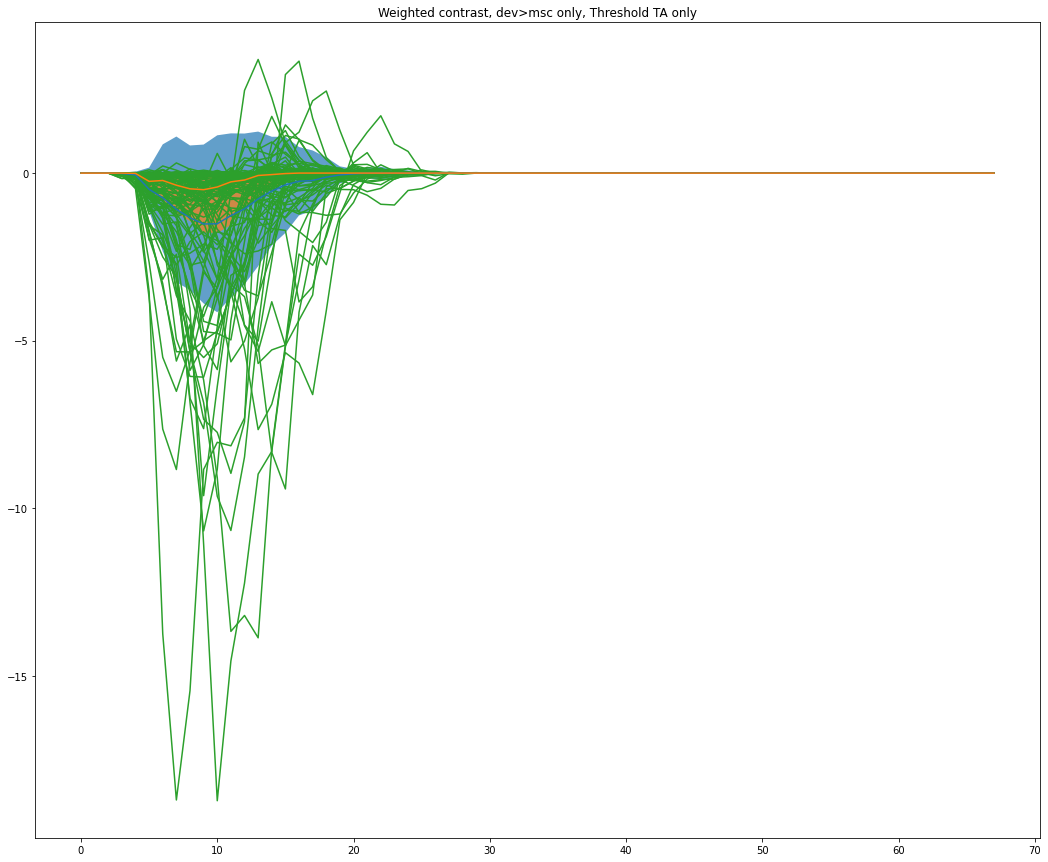

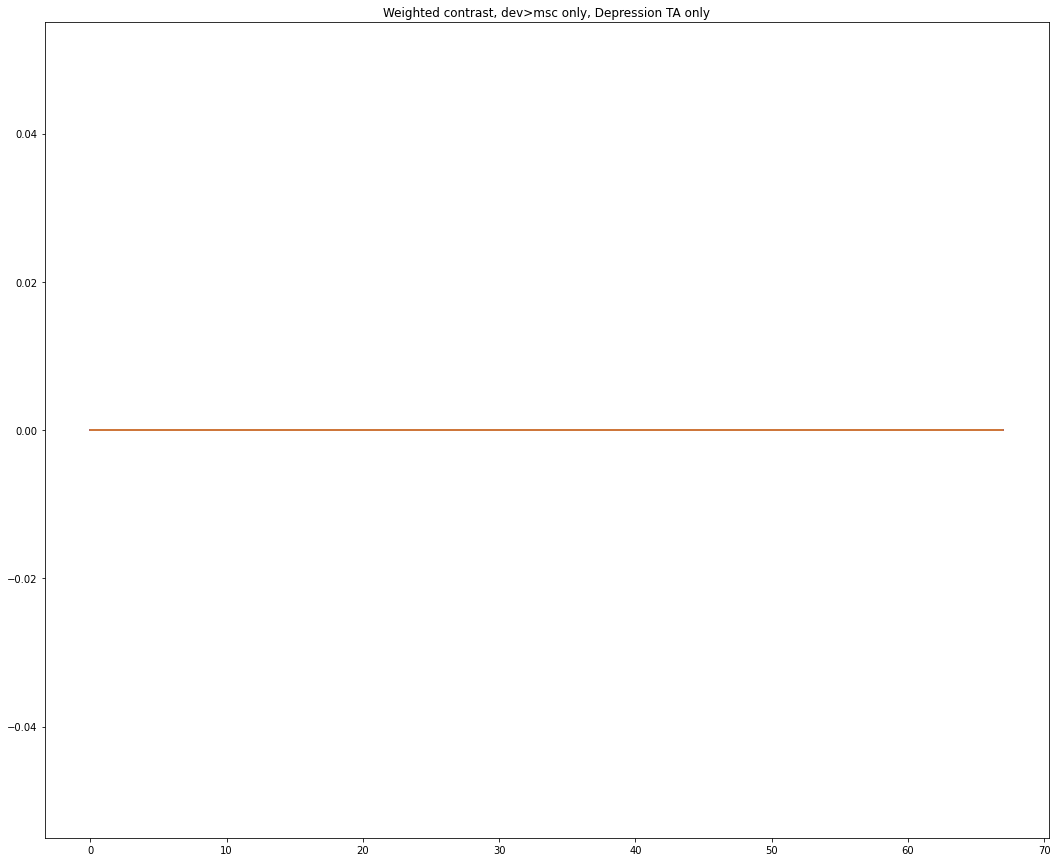

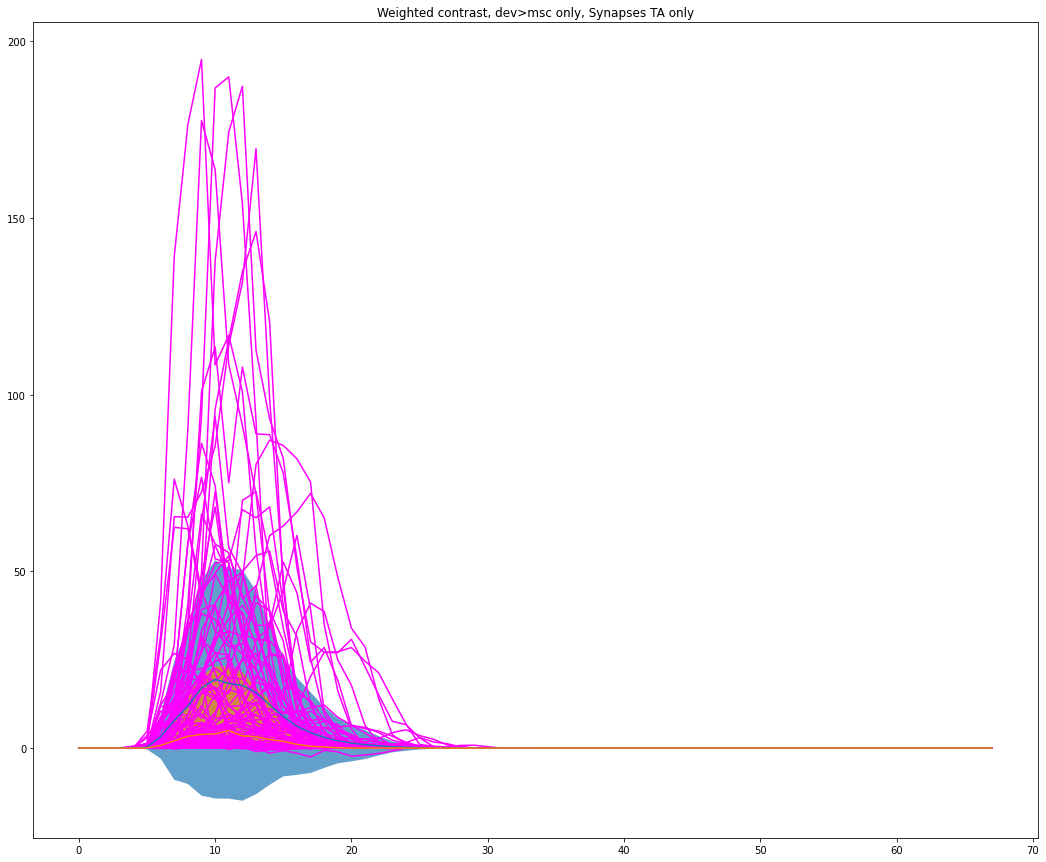

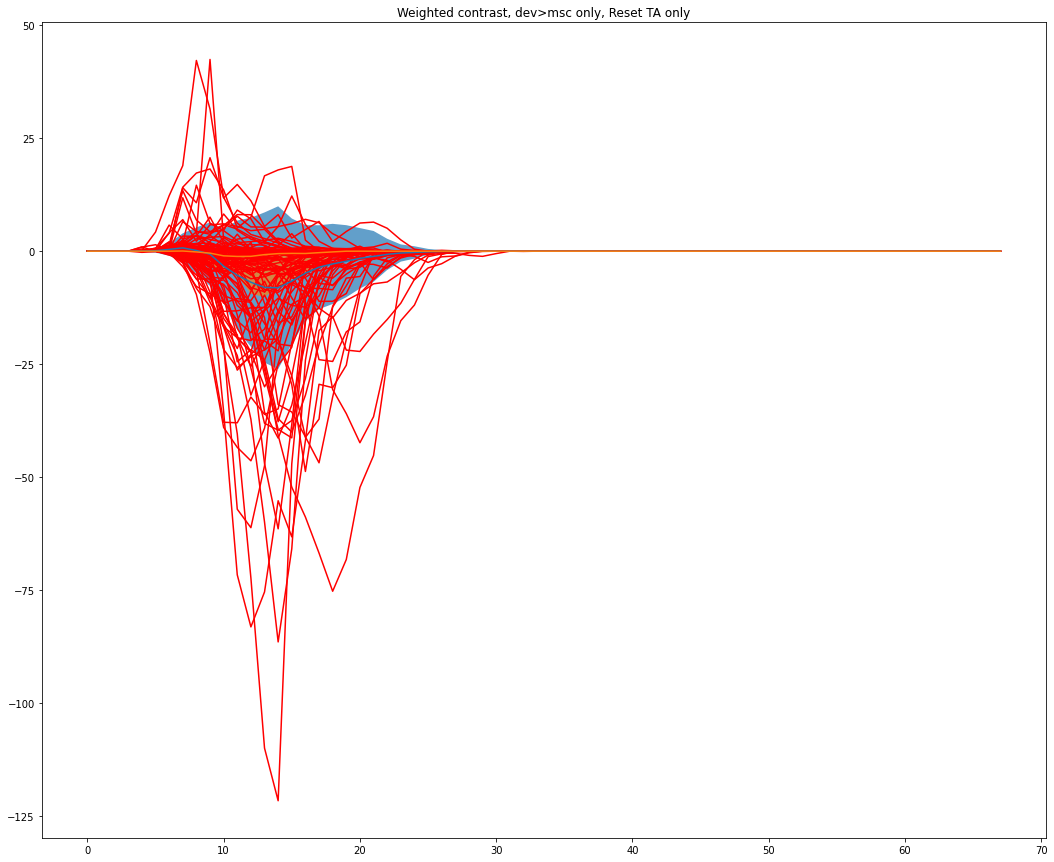

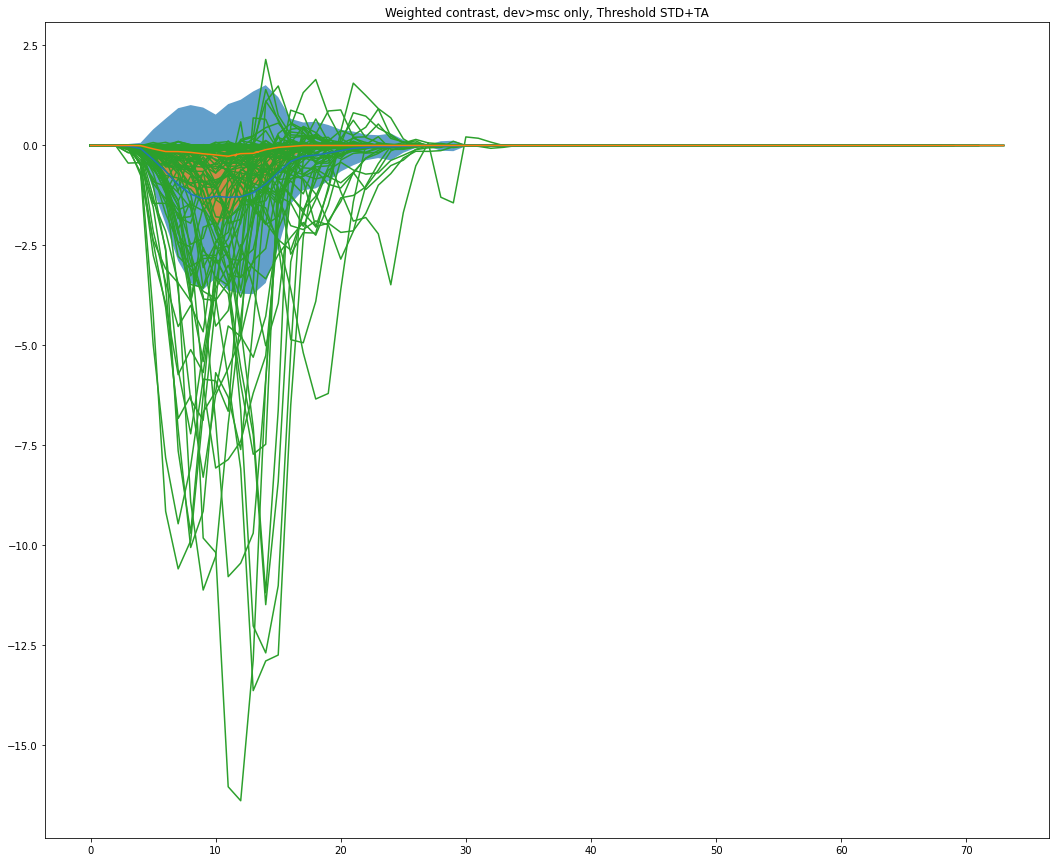

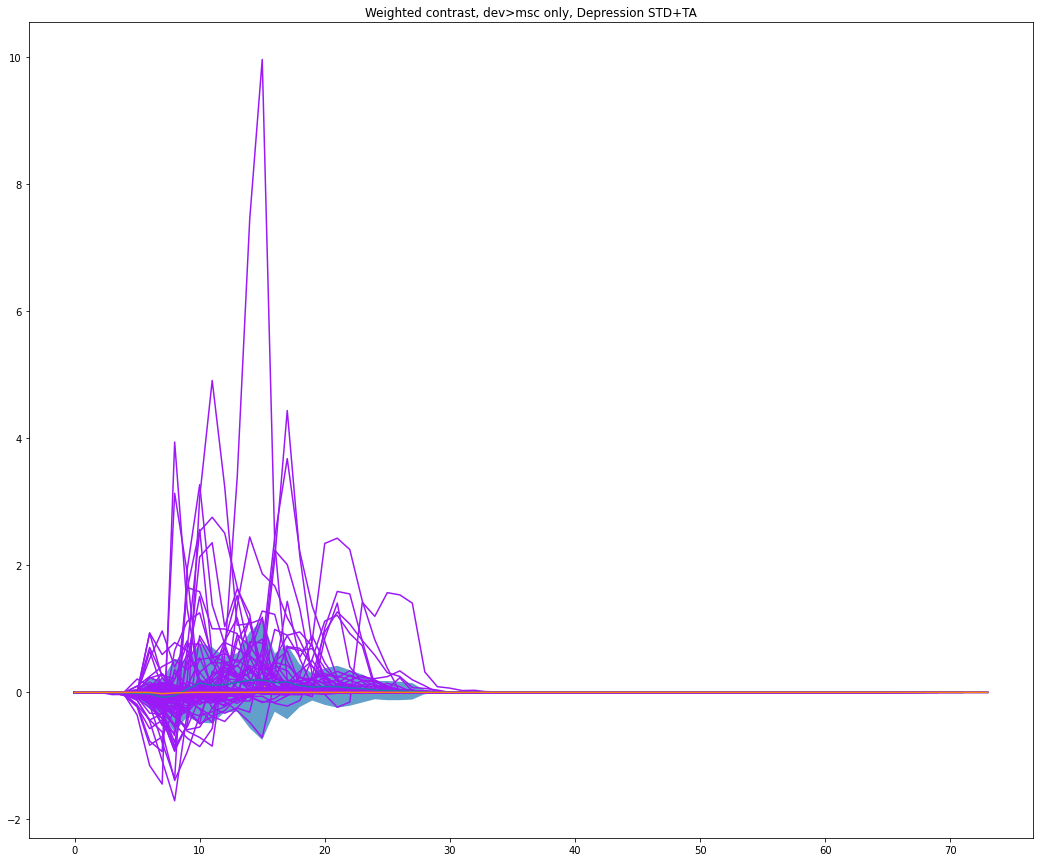

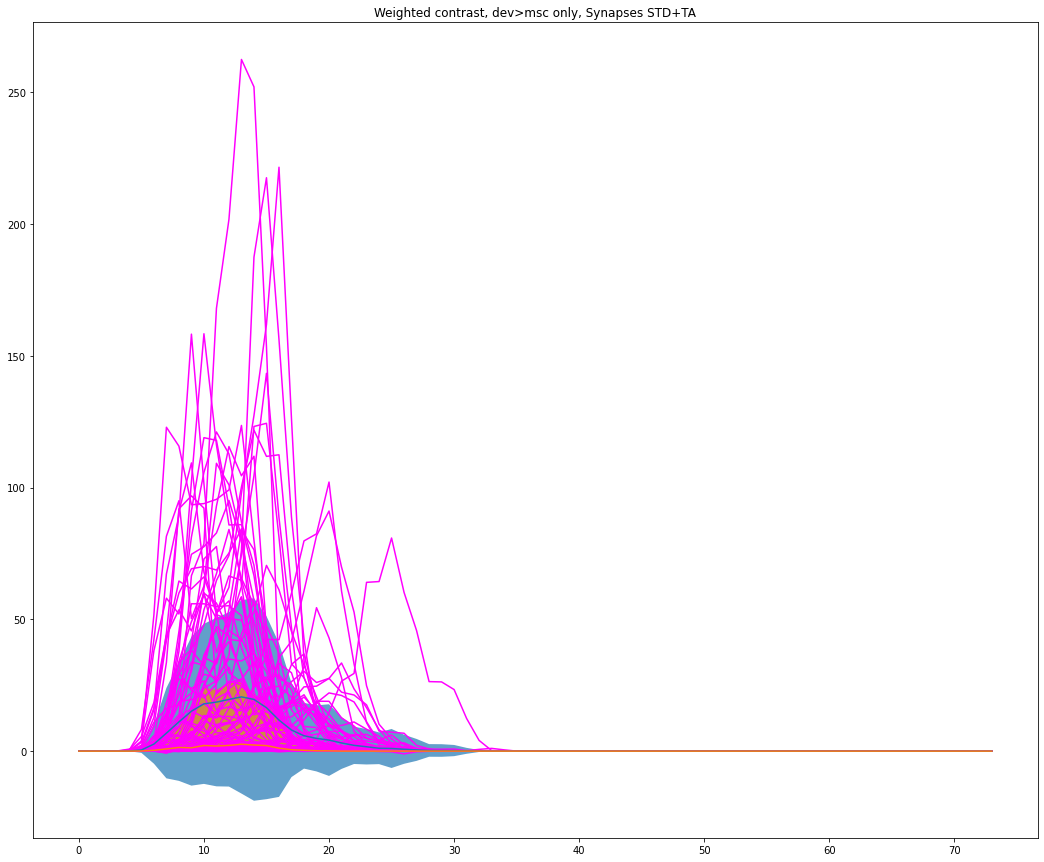

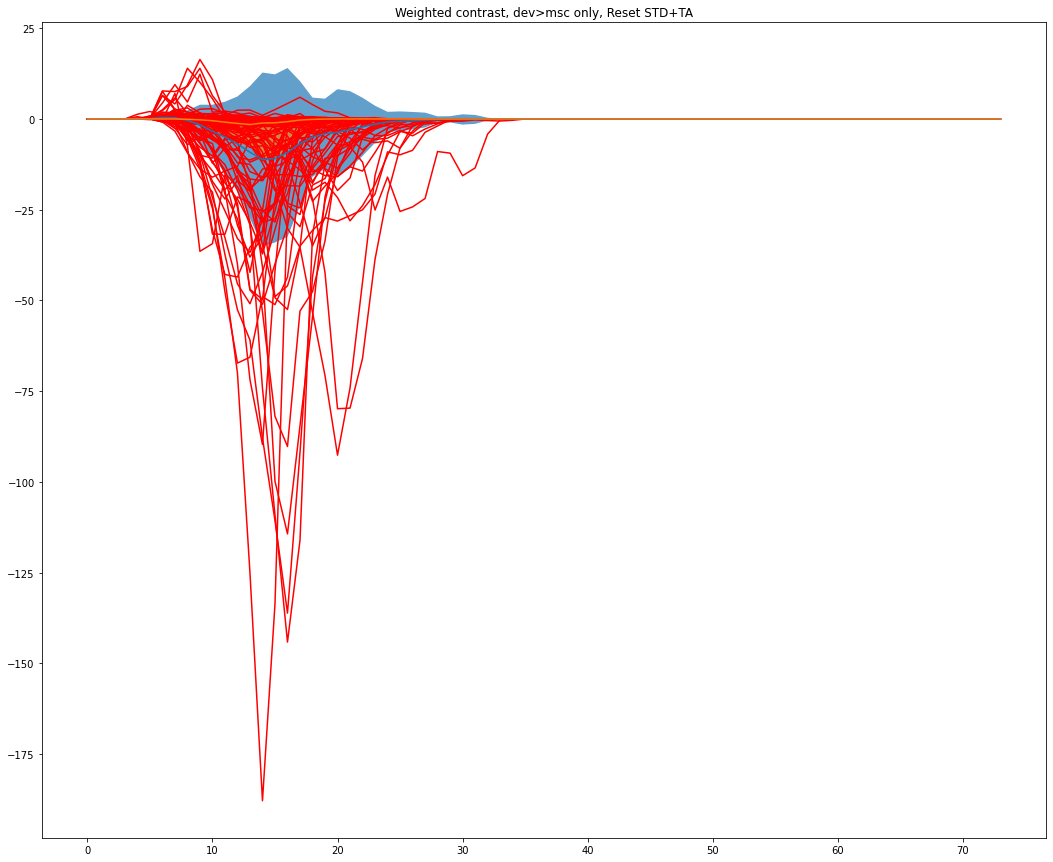

In [ ]:
time = np.arange(tmax) * cfg.params['dt'] / msecond
for STD in cfg.STDs:
    for TA in cfg.TAs:
        for measure, contrast in contrasts[STD][TA].items():
            fig, ax = plt.subplots(figsize=(18,15))
            ax.set_title(f'Weighted contrast, dev>msc only, {measure} {label(STD, TA)}')
            ax.plot(time, contrast.T, color=pu.colors[measure])
            
            m, s = np.nanmean(contrast, 0), np.nanstd(contrast, 0)
            ax.plot(time, m)
            ax.fill_between(time, m+s, m-s, alpha=.7)

            q = np.nanquantile(contrast, (.25, .5, .75), 0)
            ax.fill_between(time, q[0], q[2], alpha=.7)#color=pu.colors[measure], alpha=.2)
            ax.plot(time, q[1])#, color=pu.colors[measure], label=labelling[measure])
        # for ax in axs:
        #     ax.set_xlabel('Time (ms)')
        #     ax.set_ylabel('Weighted $\\Delta V$ (a.u.)')
        # axs[0].legend()
        # sns.despine()